In [2]:
#  This program extracts the enum packets and payload packets from the master pcap file and generates a seperate enum and 
#  payload pcap files in  seperate directories
#  Filters the payload pcap files of unwanted packets e.x packets of mouse, from the json file containing the records of file #  name, device name and window size. 
#  Splits the generated payload pcap file into pcap files of the given window size in a seperate directory. Filters the 
#  segmented pcap files for any noise pcap files (pcap files not contianing packets in both directions).
#  Splits the generated enum pcap file into pcap files of the given window size in a seperate directory.
#  Generates a csv file containing the payload features extracted from the segmented payload pcap files.
import glob
import os
import os.path
import pandas as pd
import json
import shutil
import sys
import platform
import csv
import pathlib
import itertools
import logging
import time
import math
from glob import glob
# from scapy.all import rdpcap
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
user=os.getlogin()
opdir='/home/'+user+'/Documents/Axiado-USB-Works'
source_dir= opdir+"/Pcapfiles"

denum_pcap=opdir+"/denumpcap/"
seg_pcaps=opdir+"/nwinpayloadpcap"
#logging.basicConfig(level=logging.INFO,file='featureext.log')
st_time_main=time.time()
if not os.path.isdir(opdir+'/nwinpayloadpcap'):
    os.makedirs(opdir+'/nwinpayloadpcap', exist_ok=True)
else:
    pass     
enum_pcap=opdir+"/enumpcap"
if not os.path.isdir(opdir+'/enumpcap'):
    os.makedirs(opdir+'/enumpcap', exist_ok=True)
else:
    pass     
payload_pcap=opdir+"/payloadpcap"
if not os.path.isdir(opdir+'/payloadpcap'):
    os.makedirs(opdir+'/payloadpcap', exist_ok=True)
else:
    pass     

if not os.path.isdir(opdir+'/tmpfldr'):
    os.makedirs(opdir+'/tmpfldr', exist_ok=True)
else:
    pass  
if not os.path.isdir(opdir+ '/nwinenumpcap'):
    os.makedirs(opdir+'/nwinenumpcap', exist_ok=True)
else:
    pass         
op_dir=opdir+"/tmpfldr/" 
pl_dest_file=opdir+"/Reports/pl_reports.csv"
enum_dest_file=opdir+"/Reports/enum_reports.csv"
en_pl_dest_file=opdir+"/Reports/en_pl_reports.csv"

list_pcap_files = []
list_pl_pcap_files = []
list_pckt_chckr_files= []
list_enum_pcap_files=[]
list_enum_features=[]
pl_enum_features=[]
pl_header=[]
enum_header=[]
tmp_list=[]
comblist=[]
extfilecount=0
dictlist=[]
tmphndl=sys.stdout
fhndl=open('ouput.txt','a')  
#sys.stdout=fhndl
for (dirpath, dirnames, filenames) in os.walk(source_dir):
    list_pcap_files += [os.path.join(dirpath, file) for file in filenames]
    
with open('config.json') as fl:
    addr=json.loads(fl.read())
    for i in range(len(addr)):
        wind_size=addr[i]['wind_sizep']  
print("Total no of pcap files :" + str(len(list_pcap_files)))  
print("window size is :"+ str(wind_size))


gen_features = {
		
		'fl_dur': 'none',
		'tot_fw_pk':'none',
		'tot_bw_pk':'none',
		'tot_l_fw_pkt': 'none',
		'fw_pkt_l_max': 'none',
		'fw_pkt_l_min': 'none',
		'fw_pkt_l_avg': 'none',
		'fw_pkt_l_std': 'none',
		'bw_pkt_l_max': 'none',
		'bw_pkt_l_min': 'none',
		'bw_pkt_l_mean': 'none',
		'bw_pkt_l_std': 'none',
		'fw_fl_byt_s': 'none',
		'bw_fl_byt_s': 'none',
		'fw_fl_pkt_s': 'none',
		'bw_fl_pkt_s': 'none',
		'fw_iat_tot': 'none',
		'fw_iat_avg': 'none',
		'fw_iat_std': 'none',
		'fw_iat_max': 'none',
		'fw_iat_min': 'none',
		'bw_iat_tot': 'none',
		'bw_iat_avg': 'none',
		'bw_iat_std': 'none',
		'bw_iat_max': 'none',
		'bw_iat_min': 'none',
	        'fw_pkt_s': 'none',
		'bw_pkt_s': 'none',
		'pkt_size_avg': 'none',
		'Label_code': 'none',
		'Label_Desc': 'none',
		'filename': 'none'
	}

enum_features ={
                  'enum_total_pckts':[],
                  'enum_duration':[],
                  'enum_no_HiD_requests':[],
                  'enum_no_HiD_responses':[],
                  'enum_no_bnuminterfaces':[],
                  'enum_URB_length_req':[],
                  'enum_URB_length_dlvrd':[],
                  'enum_no_setuptyp_pkt':[],
                  'enum_dev_maxpwr':[],
                  'enum_no_cntrl_trnsfr_typ_pkt':[],
                  'enum_iattot':[],
                  'enum_iatavg':[],
                  'enum_iatstd':[],
                  'enum_no_str_req':[],
                  'enum_no_str_res':[],
                  'enum_no_str_blen_bytes':[],
                  'Label_code': [],
                  'Label_Desc':[],
                  'filename':[]
                  
                  }



def enum_extracter(ip_file,fname):
    
                output_file=enum_pcap + '/' + fname
                
                os.system('tshark -r ' + ip_file + ' -Y "(usb.transfer_type==0x02)&&!(usb.device_address==1)"  ''-w' + output_file)  
                ip_enumfile=enum_pcap+'/'+ fname 
                #op_file=os.path.join(opdir,"nwinenumpcap",fname) 
                #os.system( 'editcap -c'+str(wind_size)+' '+ ip_enumfile +' '+ op_file) 
                

                
def payload_extracter(ip_file,fname):
   
    
                
                output_file=payload_pcap + '/' + fname
                os.system('tshark -r ' + ip_file + ' -Y "!(usb.transfer_type==0x02)&&!(usb.device_address==1)"  ''-w' + output_file ) 
                ip_plfile=payload_pcap+'/'+ fname
                op_file=os.path.join(opdir,"nwinpayloadpcap",fname)
                os.system( 'editcap -c'+str(wind_size)+' '+ ip_plfile +' '+ op_file)
               

def pckt_checker(filepath,fname): 
    
    
    #os.system('tshark -r '+ filepath + ' ' +'-Y "usb.src==host" '+' '+ '-w ' +  op_dir+fname )
    #tmpname=op_dir+fname
    packets = rdpcap(filepath)
    count=len(packets)
    if count<wind_size:
        os.remove(filepath)
        return
    
    
def enum_feat_extract(file_name, label,fbname):
    
    packets = rdpcap(file_name)
    count=len(packets)
    if count==0:
        return  
    else:     
        enumpcktcount=rdpcap(file_name)
        count=len(enumpcktcount)
         
        enum_features['enum_total_pckts'].append(count)
        
        opfile=opdir+'/nwinenumpcap/timeduration.csv'
        os.system('tshark -r ' + file_name +' ' +'-T'+ ' ' +'fields'+' '+'-E'+' '+' header=y'+' '+'-E'+' ' +'separator=,'+ ' '+ '-e'+ 'frame.time_relative' + '>' + opfile)
        dftimdur=pd.read_csv(opfile)
        time_duration=dftimdur['frame.time_relative'].iloc[-1]    
        os.system('rm {}'.format(opdir+'/nwinenumpcap/timeduration.csv'))
        enum_features['enum_duration'].append(time_duration)
        
       
        
        opfile=opdir+"/nwinenumpcap/op.pcap"
        os.system('tshark -r ' + file_name + ' -Y "(usbhid.descriptor.hid.bDescriptorType == 0x22)&&(usb.src==host)" ' '-w' + opfile )     
        hidreportpackets = rdpcap(opfile)  
        os.system('rm {}'.format(opfile))  
        hidcount=len(hidreportpackets)
        enum_features['enum_no_HiD_requests'].append(hidcount)
        
        
        opfile=opdir+'/nwinenumpcap/outfile.csv'
        os.system('tshark -r ' + file_name + ' ' +'-T'+ ' ' +'fields'+' '+'-E'+' '+' header=y'+' '+'-E'+' ' +'separator=,'+ ' '+ '-e'+ 'usb.bNumInterfaces' + '>' + opfile )
        dfbnumint=pd.read_csv(opfile)
        os.system('rm {}'.format(opfile))  
        enum_features['enum_no_bnuminterfaces'].append(dfbnumint['usb.bNumInterfaces'].max())
        
        
        opfile=opdir+'/nwinenumpcap/urblen.csv'
        os.system('tshark -r ' + file_name + ' ' +'-T'+ ' ' +'fields'+' '+'-E'+' '+' header=y'+' '+'-E'+' ' +'separator=,'+ ' '+ '-e'+ 'usb.urb_len'+' '+'-Y'+ 'usb.bmRequestType' + '>' + opfile)
        dfttl_requrblen=pd.read_csv(opfile)
        os.system('rm {}'.format(opfile)) 
        enum_features['enum_URB_length_req'].append(dfttl_requrblen['usb.urb_len'].sum())
        
        
        opfile=opdir+'/nwinenumpcap/urblendl.csv'
        os.system('tshark -r ' + file_name + ' ' +'-T'+ ' ' +'fields'+' '+'-E'+' '+' header=y'+' '+'-E'+' ' +'separator=,'+ ' '+ '-e'+ 'usb.urb_len'+' '+'-Y'+ '"!(usb.bmRequestType)"' + '>' + opfile)
        dfttl_requrblendl=pd.read_csv(opfile)
        os.system('rm {}'.format(opfile)) 
        enum_features['enum_URB_length_dlvrd'].append(dfttl_requrblendl['usb.urb_len'].sum())
        
        
        
        opfile=opdir+'/nwinenumpcap/bmreq0x80.csv'
        os.system('tshark -r ' + file_name + ' ' +'-T'+ ' ' +'fields'+' '+'-E'+' '+' header=y'+' '+'-E'+' ' +'separator=,'+ ' '+ '-e'+ 'usb.bmRequestType'+' '+'-Y'+ 'usb.bmRequestType==0x80' + '>' + opfile )
        dfreqtyp0x80=pd.read_csv(opfile) 
        os.system('rm {}'.format(opfile)) 
        enum_features['enum_no_setuptyp_pkt'].append(dfreqtyp0x80['usb.bmRequestType'].count())
        
        
        
        opfile=opdir+'/nwinenumpcap/bmtransfer_type0x02.csv'
        os.system('tshark -r ' + file_name + ' ' +'-T'+ ' ' +'fields'+' '+'-E'+' '+' header=y'+' '+'-E'+' ' +'separator=,'+ ' '+ '-e'+ 'usb.transfer_type'+' '+'-Y'+ 'usb.transfer_type==0x02' + '>' + opfile)
        dfreqtyp0x02=pd.read_csv(opfile)
        os.system('rm {}'.format(opfile)) 
        enum_features['enum_no_cntrl_trnsfr_typ_pkt'].append(dfreqtyp0x02['usb.transfer_type'].count())
        
        
        
        opfile=opdir+'/nwinenumpcap/stringdescreq.csv'
        os.system('tshark -r ' +file_name  + ' ' +'-T'+ ' ' +'fields'+' '+'-E'+' '+' header=y'+' '+'-E'+' ' +'separator=,'+ ' '+ '-e'+ 'usb.bmRequestType'+' '+'-Y'+ '"(usb.bmRequestType == 0x80) &&(usb.bDescriptorType == 0x03)"' + '>' + opfile)
        dfstringreq=pd.read_csv(opfile)
        os.system('rm {}'.format(opfile)) 
        enum_features['enum_no_str_req'].append(dfstringreq['usb.bmRequestType'].count())
        
        
        opfile= opdir+ '/nwinenumpcap/stringdescres.csv'
        os.system('tshark -r ' + file_name + ' ' +'-T'+ ' ' +'fields'+' '+'-E'+' '+' header=y'+' '+'-E'+' ' +'separator=,'+ ' '+ '-e'+ 'usb.bDescriptorType '+' '+'-Y'+ '"(usb.bDescriptorType == 0x03) && !(usb.setup.bRequest == 6)"' + '>' +opfile)
        dfstringres=pd.read_csv(opfile)
        os.system('rm {}'.format(opfile)) 
        enum_features['enum_no_str_res'].append(dfstringres['usb.bDescriptorType'].count())
        
        
        opfile=opdir+ '/nwinenumpcap/stringbytes.csv'
        os.system('tshark -r ' + file_name + ' ' +'-T'+ ' ' +'fields'+' '+'-E'+' '+' header=y'+' '+'-E'+' ' +'separator=,'+ ' '+ '-e'+ 'usb.bLength '+' '+'-Y'+ '"(usb.bDescriptorType == 0x03) && !(usb.setup.bRequest == 6)"' + '>' +opfile)
        dfstringresbytes=pd.read_csv(opfile)
        os.system('rm {}'.format(opfile)) 
        enum_features['enum_no_str_blen_bytes'].append(dfstringresbytes['usb.bLength'].sum())
        
        
        
        opfile= opdir+'/nwinenumpcap/maxpower.csv'
        os.system('tshark -r ' + file_name + ' ' +'-T'+ ' ' +'fields'+' '+'-E'+' '+' header=y'+' '+'-E'+' ' +'separator=,'+ ' '+ '-e'+ 'usb.bMaxPower  '+' '+'-Y'+ 'usb.bMaxPower' + '>' + opfile)
        dfmaxpower=pd.read_csv(opfile)
        os.system('rm {}'.format(opfile)) 
        enum_features['enum_dev_maxpwr'].append(dfmaxpower['usb.bMaxPower'].max())
        

        opfile= opdir+"/nwinenumpcap/hidresponse.csv"
        os.system('tshark -r' + file_name + ' ' +'-T'+ ' ' +'fields'+' '+'-E'+' '+' header=y'+' '+'-E'+' ' +'separator=,'+ ' '+ '-e'+ 'usb.src'+' '+'-Y'+ 'usbhid.item.local.usage' + '>' + opfile)
        dfhidresrep=pd.read_csv(opfile)
        os.system('rm {}'.format(opfile)) 
        enum_features['enum_no_HiD_responses'].append(dfhidresrep['usb.src'].count())
        
        
        
        opfile=opdir+'/nwinenumpcap/iat.csv'
        os.system('tshark -r' + file_name + ' ' +'-T'+ ' ' +'fields'+' '+'-E'+' '+' header=y'+' '+'-E'+' ' +'separator=,'+ ' '+ '-e'+ 'frame.time_epoch '+' '+'-Y'+ 'frame.time_epoch' + '>' + opfile)
        dfiatftrs=pd.read_csv(opfile)
        os.system('rm {}'.format(opfile)) 
        enum_features['enum_iattot'].append(dfiatftrs['frame.time_epoch'].diff().sum())
        enum_features['enum_iatavg'].append(dfiatftrs['frame.time_epoch'].diff().astype(float).mean())
        enum_features['enum_iatstd'].append(dfiatftrs['frame.time_epoch'].diff().astype(float).std())
       
        
        #enum_features['enum_osvrsn'].append(platform.version())
        
        
        
        
        if label == 0:
            enum_features['Label_code'].append('0')
            enum_features['Label_Desc'].append('Benign type')
        elif label == 1:
            enum_features['Label_code'].append('1')
            
            enum_features['Label_Desc'].append('Malicious type')
        else:
            enum_features['Label_code'].append('--')
            enum_features['Label_Desc'].append('Unknown type')
        
        
        enum_features['filename'].append(fbname)
        
        
        
def pl_feat_extract(file_name, label,itr):
    packets = rdpcap(file_name)
    count=len(packets)
    if count==0:
        return
    
     
    fields = ' -T fields -E header=y -E separator=, -e frame.number -e frame.encap_type -e frame.offset_shift -e frame.time_epoch -e frame.time_delta -e frame.time_delta_displayed -e frame.time_relative -e frame.len -e frame.cap_len -e frame.marked -e frame.ignored -e frame.protocols -e usb.src -e usb.dst -e usb.urb_id -e usb.urb_type -e usb.transfer_type -e usb.endpoint_address.direction -e usb.endpoint_address.number -e usb.device_address -e usb.bus_id -e usb.setup_flag -e usb.data_flag -e usb.urb_ts_sec -e usb.urb_ts_usec -e usb.urb_status -e usb.urb_len -e usb.data_len -e usb.bInterfaceClass -e usb.interval -e usb.start_frame -e usb.copy_of_transfer_flags -e usb.transfer_flags.short_not_ok -e usb.transfer_flags.iso_asap -e usb.transfer_flags.no_fsbr -e usb.transfer_flags.zero_packet -e usb.transfer_flags.no_interrupt -e usb.transfer_flags.free_buffer -e usb.transfer_flags.dir_in -e usb.transfer_flags.dma_map_single -e usb.transfer_flags.dma_map_sg -e usb.transfer_flags.map_local -e usb.transfer_flags.setup_map_single -e usb.transfer_flags.setup_map_local -e usb.transfer_flags.dma_sg_combined -e usb.transfer_flags.aligned_temp_buffer -e usb.iso.numdesc '

    os.system('tshark -r ' + file_name + ' -Y "(usb.dst == host)"' + fields + '-e usb.capdata -e frame.time > pl_backward.csv')
    os.system('tshark -r ' + file_name + ' -Y "(usb.src == host)"' + fields + '-e frame.time > pl_forward.csv')    
    
    csv_list = ['pl_backward.csv', 'pl_forward.csv']
    new_csv_list = ['pl_backwardnew.csv', 'pl_forwardnew.csv']
    
    for j in range(2):
        with open(csv_list[j], 'r') as fin, open(new_csv_list[j], 'w') as fout:
            first_line = fin.readline()
            fout.write(first_line)
            while (curr_line := fin.readline()):
                str_len = len(curr_line)
                for i in range(str_len-1, -1, -1):
                    if curr_line[i] == ',':
                        comma_pos = i
                        break
                curr_line = curr_line[0:comma_pos] + curr_line[comma_pos+1:]
                fout.write(curr_line)            
                            
        fin.close()
        fout.close()
        os.system('rm {}'.format(csv_list[j]))
            
    dfb = pd.read_csv(new_csv_list[0])
    dff = pd.read_csv(new_csv_list[1])
        
    time_min = dff['frame.time_epoch'].iloc[0] if (dff['frame.time_epoch'].iloc[0] < dfb['frame.time_epoch'].iloc[0]) else dfb['frame.time_epoch'].iloc[0]
    time_max = dff['frame.time_epoch'].iloc[-1] if (dff['frame.time_epoch'].iloc[-1] > dfb['frame.time_epoch'].iloc[-1]) else dfb['frame.time_epoch'].iloc[-1]
    tot_time = (time_max - time_min)
        
    gen_features['fl_dur']=tot_time
    #print('fl_dur:',gen_features['fl_dur'])    
    
    gen_features['tot_fw_pk']=dff.index.size
    #print('tot_fw_pk:',gen_features['tot_fw_pk'])     
    
    gen_features['tot_bw_pk']=dfb.index.size
    #print('tot_bw_pk:',gen_features['tot_bw_pk'])
        
    gen_features['tot_l_fw_pkt']=dff['frame.cap_len'].sum()
    #print('tot_l_fw_pkt:',gen_features['tot_l_fw_pkt'])  
      
    gen_features['fw_pkt_l_max']=dff['frame.cap_len'].max()
    #print('fw_pkt_l_max:',gen_features['fw_pkt_l_max'])
        
    gen_features['fw_pkt_l_min']=dff['frame.cap_len'].min()
    #print('fw_pkt_l_min:',gen_features['fw_pkt_l_min'])
        
    gen_features['fw_pkt_l_avg']=dff['frame.cap_len'].astype(float).mean()
    #print('fw_pkt_l_avg:',gen_features['fw_pkt_l_avg'])
        
    gen_features['fw_pkt_l_std']=dff['frame.cap_len'].astype(float).std()
    #print('fw_pkt_l_std:',gen_features['fw_pkt_l_avg'])
        
    gen_features['bw_pkt_l_max']=dfb['frame.cap_len'].max()
    #print('bw_pkt_l_max:',gen_features['bw_pkt_l_max'])
        
    gen_features['bw_pkt_l_min']=dfb['frame.cap_len'].min()
    #print('bw_pkt_l_min:',gen_features['bw_pkt_l_min'])
        
    gen_features['bw_pkt_l_mean']=dfb['frame.cap_len'].astype(float).mean()
    #print('bw_pkt_l_mean:',gen_features['bw_pkt_l_mean'])
        
    gen_features['bw_pkt_l_std']=dfb['frame.cap_len'].astype(float).std()
    #print('bw_pkt_l_std:',gen_features['bw_pkt_l_std'])
        
    gen_features['fw_fl_byt_s']=dff['frame.cap_len'].sum().astype(float)/tot_time
    #print('fw_fl_byt_s:',gen_features['fw_fl_byt_s'])
        
    gen_features['bw_fl_byt_s']=dfb['frame.cap_len'].sum().astype(float)/tot_time
    #print('bw_fl_byt_s:',gen_features['bw_fl_byt_s'])
        
    gen_features['fw_fl_pkt_s']=dff.index.size/tot_time
    #print('fw_fl_pkt_s:',gen_features['fw_fl_pkt_s'])
        
    gen_features['bw_fl_pkt_s']=dfb.index.size/tot_time
    #print('bw_fl_pkt_s:',gen_features['bw_fl_pkt_s'])
        
    gen_features['fw_iat_tot']=dff['frame.time_epoch'].diff().sum()
    #print('fw_iat_tot:',gen_features['fw_iat_tot'])
        
    gen_features['fw_iat_avg']=dff['frame.time_epoch'].diff().astype(float).mean()
    #print('fw_iat_avg:',gen_features['fw_iat_avg'])
        
    
    gen_features['fw_iat_std']=dff['frame.time_epoch'].diff().astype(float).std()   
    #print('fw_iat_std:',gen_features['fw_iat_std'])   
    
    gen_features['fw_iat_max']=dff['frame.time_epoch'].diff().max()
    #print('fw_iat_max:',gen_features['fw_iat_max'])
        
    gen_features['fw_iat_min']=dff['frame.time_epoch'].diff().min()
    #print('fw_iat_min:',gen_features['fw_iat_min'])
        
    gen_features['bw_iat_tot']=dfb['frame.time_epoch'].diff().sum()
    #print('bw_iat_tot:',gen_features['bw_iat_tot'])
        
    gen_features['bw_iat_avg']=dfb['frame.time_epoch'].diff().astype(float).mean()
    #print('bw_iat_avg:',gen_features['bw_iat_avg'])
        
    
    
    gen_features['bw_iat_std']=dfb['frame.time_epoch'].diff().astype(float).std()     
    #print('bw_iat_std:',gen_features['fw_iat_std'])         
             
    gen_features['bw_iat_max']=dfb['frame.time_epoch'].diff().max()
    #print('bw_iat_max:',gen_features['bw_iat_max'])     
        
    gen_features['bw_iat_min']=dfb['frame.time_epoch'].diff().min()
    #print('bw_iat_min:',gen_features['bw_iat_min'])     
        
    time_f = dff['frame.time_epoch'].iloc[-1] - dff['frame.time_epoch'].iloc[0] 
        
    time_b = dfb['frame.time_epoch'].iloc[-1] - dfb['frame.time_epoch'].iloc[0]
    if time_f==0: 
        gen_features['fw_pkt_s']=0
        #print('fw_pkt_s:',gen_features['fw_pkt_s'])
    else: 
        gen_features['fw_pkt_s']= dff.index.size/time_f
        #print('fw_pkt_s:',gen_features['fw_pkt_s'])
        
    if time_b==0: 
        gen_features['bw_pkt_s']=0
        #print('bw_pkt_s:',gen_features['bw_pkt_s'])
    else:     
        gen_features['bw_pkt_s']=dfb.index.size/time_b
        #print('bw_pkt_s:',gen_features['bw_pkt_s'])
        
    gen_features['pkt_size_avg']=(dff['frame.cap_len'].sum()+dfb['frame.cap_len'].sum())/((dff.index.size+dfb.index.size))  
    #print('pkt_size_avg:',gen_features['pkt_size_avg'])  
        
    if label == 0:
        gen_features['Label_code']='0'
        gen_features['Label_Desc']='Benign type'
        #print('Label_code:',gen_features['Label_code']) 
        #print('Label_Desc:',gen_features['Label_Desc'])  
    elif label == 1:
        gen_features['Label_code']='1'
        gen_features['Label_Desc']='Malicious type'
        #print('Label_code:',gen_features['Label_code']) 
        #print('Label_Desc:',gen_features['Label_Desc'])  
    else:
        gen_features['Label_code'].append('--')
        gen_features['Label_Desc'].append('Unknown type')
               
    filepath=os.path.basename(file_name)
    gen_features['filename']=filepath
    #print('filename:',gen_features['filename'])
    
    
    featuresdf = pd.DataFrame.from_dict([gen_features])
    if itr==0:
        featuresdf.to_csv(pl_dest_file,mode='a')
    else:
        featuresdf.to_csv(pl_dest_file,mode='a',header=False)    
    
    
    #os.system('rm {}'.format(new_csv_list[0]))
    #os.system('rm {}'.format(new_csv_list[1]))

def extract_features_from_csv(file_name, label):
    # Load the CSV data
    df = pd.read_csv(file_name)

    # Initialize the list to hold flow-based features
    features_list = []

    # Iterate over the CSV file in chunks of 6 packets (creating "flows")
    for i in range(0, len(df), 6):
        flow = df.iloc[i:i+6]  # Take the current flow (6 packets)

        if len(flow) < 6:
            # Skip incomplete flows with less than 6 packets
            continue

        # Compute the effective packet length as data_length + 48
        flow['packet_length'] = flow['data_length'] + 48

        # Split into forward (urb_direction == 8) and backward (urb_direction == 0)
        fw_flow = flow[flow['urb_direction'] == 8]
        bw_flow = flow[flow['urb_direction'] == 0]

        # Packet count and length-based features
        tot_fw_pk = len(fw_flow)  # Total forward packets
        tot_bw_pk = len(bw_flow)  # Total backward packets

        tot_l_fw_pkt = fw_flow['packet_length'].sum() if not fw_flow.empty else 0  # Total size of packet in forward direction
        fw_pkt_l_max = fw_flow['packet_length'].max() if not fw_flow.empty else 0  # Max size of packet in forward direction
        fw_pkt_l_min = fw_flow['packet_length'].min() if not fw_flow.empty else 0  # Min size of packet in forward direction
        fw_pkt_l_avg = fw_flow['packet_length'].mean() if not fw_flow.empty else 0  # Average size of packet in forward direction
        fw_pkt_l_std = fw_flow['packet_length'].std() if not fw_flow.empty else 0  # Std dev of packet sizes in forward direction

        tot_l_bw_pkt = bw_flow['packet_length'].sum() if not bw_flow.empty else 0  # Total size of packet in backward direction
        bw_pkt_l_max = bw_flow['packet_length'].max() if not bw_flow.empty else 0  # Max size of packet in backward direction
        bw_pkt_l_min = bw_flow['packet_length'].min() if not bw_flow.empty else 0  # Min size of packet in backward direction
        bw_pkt_l_avg = bw_flow['packet_length'].mean() if not bw_flow.empty else 0  # Average size of packet in backward direction
        bw_pkt_l_std = bw_flow['packet_length'].std() if not bw_flow.empty else 0  # Std dev of packet sizes in backward direction

        # Time-based features
        if not fw_flow.empty:
            start_time = fw_flow.iloc[0]['urb_sec'] + fw_flow.iloc[0]['urb_usec'] / 1e6
        else:
            start_time = 0

        if not bw_flow.empty:
            end_time = bw_flow.iloc[-1]['urb_sec'] + bw_flow.iloc[-1]['urb_usec'] / 1e6
        else:
            end_time = 0

        flow_duration = end_time - start_time  # Flow duration

        # Calculate IAT (Inter Arrival Time) for forward direction
        if not fw_flow.empty:
            fw_time_deltas = fw_flow['urb_sec'].diff().fillna(0) + fw_flow['urb_usec'].diff().fillna(0) / 1e6
            fw_iat_tot = fw_time_deltas.sum()  # Sum of inter-arrival times
            fw_iat_avg = fw_time_deltas.mean()  # Average inter-arrival time
            fw_iat_std = fw_time_deltas.std()  # Std dev of inter-arrival times
            fw_iat_max = fw_time_deltas.max()  # Max inter-arrival time
            fw_iat_min = fw_time_deltas.min()  # Min inter-arrival time
        else:
            fw_iat_tot = fw_iat_avg = fw_iat_std = fw_iat_max = fw_iat_min = 0

        # Calculate IAT for backward direction
        if not bw_flow.empty:
            bw_time_deltas = bw_flow['urb_sec'].diff().fillna(0) + bw_flow['urb_usec'].diff().fillna(0) / 1e6
            bw_iat_tot = bw_time_deltas.sum()  # Sum of inter-arrival times
            bw_iat_avg = bw_time_deltas.mean()  # Average inter-arrival time
            bw_iat_std = bw_time_deltas.std()  # Std dev of inter-arrival times
            bw_iat_max = bw_time_deltas.max()  # Max inter-arrival time
            bw_iat_min = bw_time_deltas.min()  # Min inter-arrival time
        else:
            bw_iat_tot = bw_iat_avg = bw_iat_std = bw_iat_max = bw_iat_min = 0

        # Flow byte rate (bytes per second) for forward and backward direction
        if flow_duration > 0:
            fw_fl_byt_s = tot_l_fw_pkt / flow_duration if tot_l_fw_pkt > 0 else 0
            bw_fl_byt_s = tot_l_bw_pkt / flow_duration if tot_l_bw_pkt > 0 else 0
        else:
            fw_fl_byt_s = bw_fl_byt_s = 0

        # Compile the features into a dictionary
        features = {
            'tot_fw_pk': tot_fw_pk,
            'tot_bw_pk': tot_bw_pk,
            'tot_l_fw_pkt': tot_l_fw_pkt,
            'fw_pkt_l_max': fw_pkt_l_max,
            'fw_pkt_l_min': fw_pkt_l_min,
            'fw_pkt_l_avg': fw_pkt_l_avg,
            'fw_pkt_l_std': fw_pkt_l_std,
            'tot_l_bw_pkt': tot_l_bw_pkt,
            'bw_pkt_l_max': bw_pkt_l_max,
            'bw_pkt_l_min': bw_pkt_l_min,
            'bw_pkt_l_avg': bw_pkt_l_avg,
            'bw_pkt_l_std': bw_pkt_l_std,
            'fl_dur': flow_duration,
            'fw_fl_byt_s': fw_fl_byt_s,
            'bw_fl_byt_s': bw_fl_byt_s,
            'fw_iat_tot': fw_iat_tot,
            'fw_iat_avg': fw_iat_avg,
            'fw_iat_std': fw_iat_std,
            'fw_iat_max': fw_iat_max,
            'fw_iat_min': fw_iat_min,
            'bw_iat_tot': bw_iat_tot,
            'bw_iat_avg': bw_iat_avg,
            'bw_iat_std': bw_iat_std,
            'bw_iat_max': bw_iat_max,
            'bw_iat_min': bw_iat_min,
            'Label_code': label,
            'Label_Desc': 'Benign' if label == 0 else 'Malicious'
        }

        # Append the features to the list
        features_list.append(features)

    # Convert the list of dictionaries into a DataFrame
    features_df = pd.DataFrame(features_list)

    # Save to a CSV file
    output_file = os.path.splitext(file_name)[0] + "_features.csv"
    features_df.to_csv(output_file, index=False)

    print(f"Feature extraction completed. Saved to {output_file}")
    
    
if __name__ == "__main__":
    
    list_pcap_files.sort()
    print("Extracting enum and payload pcap files ")
    for i, f in enumerate(list_pcap_files):
            
            filename=os.path.basename(f)
            #denum_extracter(f,filename)
            
            extfilecount= extfilecount + 1
            
            
            enum_extracter(f,filename)
            payload_extracter(f,filename)
            if extfilecount%25==0:
                print(str(extfilecount)+" enum and payload pcap files extracted from " + str(len(list_pcap_files))+" master pcap files")
            
            
    print(" Total " + str(extfilecount) +" enum pcapfiles extracted out of " + str(len(list_pcap_files)) +" master pcap files")        
    
            
    for (dirpath, dirnames, pckt_chckr) in os.walk(seg_pcaps):
        list_pckt_chckr_files += [os.path.join(dirpath, file) for file in pckt_chckr]
    print( str(len(list_pckt_chckr_files)) + " " +str(wind_size)+"-window payload pcap files have been generated")
    print("checking for valid payload pcap files--> starting pckt checker")
    extfilecount=0
    for i, f in enumerate(list_pckt_chckr_files):
        pchkr_filename=os.path.basename(f) 
        extfilecount= extfilecount + 1
        pckt_checker(f,pchkr_filename) 
        if extfilecount%25==0:
            print( str(extfilecount) + " payload pcap files checked out of " + str(len(list_pckt_chckr_files)) + " files")  
        
        
    extfilecount=0
    for (dirpath, dirnames, pl_filenames) in os.walk(seg_pcaps):
        list_pl_pcap_files += [os.path.join(dirpath, file) for file in pl_filenames]
        
    print(" Total " + str(len(list_pl_pcap_files)) +" valid " +str(wind_size) +"-window  payload pcap files are generated")
        
    list_pl_pcap_files.sort() 
    print("Extracting payload features ") 
   
         
    for i, f in enumerate(list_pl_pcap_files):  
        
        pl_filename=os.path.basename(f)
        if "Attack".lower() in pl_filename.lower():
            label=1
        else:
            label=0
        
        
        extfilecount= extfilecount + 1
                  
        pl_feat_extract(f, label,i)  
        if extfilecount%25==0:
            print("Payload features extracted from "+ str(extfilecount) + " out of  " + str(len(list_pl_pcap_files)) + " files")  
            
    print("Payload features extraction completed")
    
    #featuresdf = pd.DataFrame.from_dict(gen_features)
    #featuresdf.to_csv(pl_dest_file,mode='a')
    #shutil.rmtree(opdir+'/tmpfldr')
    # enum feature extraction
    extfilecount=0
    for (dirpath, dirnames, enum_filenames) in os.walk(enum_pcap):
        list_enum_pcap_files += [os.path.join(dirpath, file) for file in enum_filenames]
        
    print(" starting enum feature extraction")    
    list_enum_pcap_files.sort()    
    extfilecount=0
    for i, f in enumerate(list_enum_pcap_files):  
        
        enum_filename=os.path.basename(f)
        if "Attack".lower() in enum_filename.lower():
            label=1
        else:
            label=0
        
        extfilecount= extfilecount + 1
        if extfilecount%25==0:
            print("enum features extracted from "+ str(extfilecount) + " out of  " + str(len(list_enum_pcap_files)) + " files")       
        enum_feat_extract(f, label,enum_filename) 
    print("enum features extraction completed")   
    print("Generated enum and payload CSV files") 
    enumfeaturesdf = pd.DataFrame.from_dict(enum_features)
    enumfeaturesdf.to_csv(enum_dest_file,mode='a') 
    print("Successfully generated enum and payload feature files in report directory")
    
print("Merging both enum and payload feature files")    
ind_pl_row=0 
pl_data=pd.read_csv(pl_dest_file)
enum_data=pd.read_csv(enum_dest_file)
for column in pl_data.columns:
    pl_header.append(column)
   # pl_header[0]="ser_no"
for column in enum_data.columns:
    enum_header.append(column)  
#enum_headerup=enum_header[1:]
header=pl_header + enum_header
with open(en_pl_dest_file, "a", newline='') as enum_pl:
    write_en_pl=csv.writer(enum_pl)
    write_en_pl.writerow(header)
print("Sucessfully copied the headers from both enum and payload files")
print("copying data from enum and payload csv files to the merge file")
for enum_row in range(len(enum_data)):
    enum_tmp_list=enum_data.loc[enum_row]
    enum_fname=enum_tmp_list[-1]
    
    for pl_row in range(ind_pl_row,len(pl_data)):
        pl_tmp_list=pl_data.loc[pl_row]        
        pl_fname=pl_tmp_list[-1]
        index=-1
        index1=-1
        if (pl_fname.find('benign')!=-1):
            index=pl_fname.find('benign')
            tmpfname=pl_fname[:index+len('benign')]        
        else:
            index1=pl_fname.find('attack')
            tmpfname=pl_fname[:index1+len('attack')]
        fileext=pathlib.Path(pl_fname).suffix
        pl_fname=tmpfname+fileext  
       
        if pl_fname.lower() == enum_fname.lower():
            comblist=[pl_tmp_list,enum_tmp_list]
            result=pd.concat(comblist)
            with open(en_pl_dest_file, "a", newline='') as enum_pl:
                write_en_pl=csv.writer(enum_pl)
                write_en_pl.writerow(result.values)
        else:
            ind_pl_row=pl_row
            break   
   
print("completed creating the merged feature file")   
shutil.rmtree(opdir+'/tmpfldr')
shutil.rmtree(opdir+'/nwinpayloadpcap')
shutil.rmtree(opdir+'/enumpcap')
shutil.rmtree(opdir+'/payloadpcap')        
shutil.rmtree(opdir+'/nwinenumpcap')                 
et_time_main=time.time()  
prgexectime=et_time_main-st_time_main

print("total execution of the entire program:",time.strftime("%H:%M:%S", time.gmtime(prgexectime)))      
fhndl.close()            



    
        
    
    

In [3]:
def extract_features_from_csv(file_name, label):
    # Load the CSV data
    df = pd.read_csv(file_name)

    # Initialize the list to hold flow-based features
    features_list = []

    # Iterate over the CSV file in chunks of 6 packets (creating "flows")
    for i in range(0, len(df), 6):
        flow = df.iloc[i:i+6]  # Take the current flow (6 packets)

        if len(flow) < 6:
            # Skip incomplete flows with less than 6 packets
            continue

        # Compute the effective packet length as data_length + 48
        flow['packet_length'] = flow['data_length'] + 48

        # Split into forward (urb_direction == 8) and backward (urb_direction == 0)
        fw_flow = flow[flow['urb_direction'] == 8]
        bw_flow = flow[flow['urb_direction'] == 0]

        # Packet count and length-based features
        tot_fw_pk = len(fw_flow)  # Total forward packets
        tot_bw_pk = len(bw_flow)  # Total backward packets

        tot_l_fw_pkt = fw_flow['packet_length'].sum() if not fw_flow.empty else 0  # Total size of packet in forward direction
        fw_pkt_l_max = fw_flow['packet_length'].max() if not fw_flow.empty else 0  # Max size of packet in forward direction
        fw_pkt_l_min = fw_flow['packet_length'].min() if not fw_flow.empty else 0  # Min size of packet in forward direction
        fw_pkt_l_avg = fw_flow['packet_length'].mean() if not fw_flow.empty else 0  # Average size of packet in forward direction
        fw_pkt_l_std = fw_flow['packet_length'].std() if not fw_flow.empty else 0  # Std dev of packet sizes in forward direction

        tot_l_bw_pkt = bw_flow['packet_length'].sum() if not bw_flow.empty else 0  # Total size of packet in backward direction
        bw_pkt_l_max = bw_flow['packet_length'].max() if not bw_flow.empty else 0  # Max size of packet in backward direction
        bw_pkt_l_min = bw_flow['packet_length'].min() if not bw_flow.empty else 0  # Min size of packet in backward direction
        bw_pkt_l_avg = bw_flow['packet_length'].mean() if not bw_flow.empty else 0  # Average size of packet in backward direction
        bw_pkt_l_std = bw_flow['packet_length'].std() if not bw_flow.empty else 0  # Std dev of packet sizes in backward direction

        # Time-based features
        if not fw_flow.empty:
            start_time = fw_flow.iloc[0]['urb_sec'] + fw_flow.iloc[0]['urb_usec'] / 1e6
        else:
            start_time = 0

        if not bw_flow.empty:
            end_time = bw_flow.iloc[-1]['urb_sec'] + bw_flow.iloc[-1]['urb_usec'] / 1e6
        else:
            end_time = 0

        flow_duration = end_time - start_time  # Flow duration

        # Calculate IAT (Inter Arrival Time) for forward direction
        if not fw_flow.empty:
            fw_time_deltas = fw_flow['urb_sec'].diff().fillna(0) + fw_flow['urb_usec'].diff().fillna(0) / 1e6
            fw_iat_tot = fw_time_deltas.sum()  # Sum of inter-arrival times
            fw_iat_avg = fw_time_deltas.mean()  # Average inter-arrival time
            fw_iat_std = fw_time_deltas.std()  # Std dev of inter-arrival times
            fw_iat_max = fw_time_deltas.max()  # Max inter-arrival time
            fw_iat_min = fw_time_deltas.min()  # Min inter-arrival time
        else:
            fw_iat_tot = fw_iat_avg = fw_iat_std = fw_iat_max = fw_iat_min = 0

        # Calculate IAT for backward direction
        if not bw_flow.empty:
            bw_time_deltas = bw_flow['urb_sec'].diff().fillna(0) + bw_flow['urb_usec'].diff().fillna(0) / 1e6
            bw_iat_tot = bw_time_deltas.sum()  # Sum of inter-arrival times
            bw_iat_avg = bw_time_deltas.mean()  # Average inter-arrival time
            bw_iat_std = bw_time_deltas.std()  # Std dev of inter-arrival times
            bw_iat_max = bw_time_deltas.max()  # Max inter-arrival time
            bw_iat_min = bw_time_deltas.min()  # Min inter-arrival time
        else:
            bw_iat_tot = bw_iat_avg = bw_iat_std = bw_iat_max = bw_iat_min = 0

        # Flow byte rate (bytes per second) for forward and backward direction
        if flow_duration > 0:
            fw_fl_byt_s = tot_l_fw_pkt / flow_duration if tot_l_fw_pkt > 0 else 0
            bw_fl_byt_s = tot_l_bw_pkt / flow_duration if tot_l_bw_pkt > 0 else 0
        else:
            fw_fl_byt_s = bw_fl_byt_s = 0

        # Compile the features into a dictionary
        features = {
            'tot_fw_pk': tot_fw_pk,
            'tot_bw_pk': tot_bw_pk,
            'tot_l_fw_pkt': tot_l_fw_pkt,
            'fw_pkt_l_max': fw_pkt_l_max,
            'fw_pkt_l_min': fw_pkt_l_min,
            'fw_pkt_l_avg': fw_pkt_l_avg,
            'fw_pkt_l_std': fw_pkt_l_std,
            'tot_l_bw_pkt': tot_l_bw_pkt,
            'bw_pkt_l_max': bw_pkt_l_max,
            'bw_pkt_l_min': bw_pkt_l_min,
            'bw_pkt_l_avg': bw_pkt_l_avg,
            'bw_pkt_l_std': bw_pkt_l_std,
            'fl_dur': flow_duration,
            'fw_fl_byt_s': fw_fl_byt_s,
            'bw_fl_byt_s': bw_fl_byt_s,
            'fw_iat_tot': fw_iat_tot,
            'fw_iat_avg': fw_iat_avg,
            'fw_iat_std': fw_iat_std,
            'fw_iat_max': fw_iat_max,
            'fw_iat_min': fw_iat_min,
            'bw_iat_tot': bw_iat_tot,
            'bw_iat_avg': bw_iat_avg,
            'bw_iat_std': bw_iat_std,
            'bw_iat_max': bw_iat_max,
            'bw_iat_min': bw_iat_min,
            'Label_code': label,
            'Label_Desc': 'Benign' if label == 0 else 'Malicious'
        }

        # Append the features to the list
        features_list.append(features)

    # Convert the list of dictionaries into a DataFrame
    features_df = pd.DataFrame(features_list)

    # Save to a CSV file
    output_file = os.path.splitext(file_name)[0] + "_features.csv"
    features_df.to_csv(output_file, index=False)

    print(f"Feature extraction completed. Saved to {output_file}")

In [8]:
# Load your CSV file
file_name = 'vm_flashdrive.csv'  # Replace with the path to your file
# df = pd.read_csv(file_name, usecols=range(15))  # Select only the first 15 columns

# Save the cleaned CSV with only the first 15 columns
output_file = 'vm_flashdrive_mod.csv'  # Replace with the desired output file name
# df.to_csv(output_file, index=False)
with open(file_name, 'r') as infile, open(output_file, 'w', newline='') as outfile:
    reader = csv.reader(infile)
    writer = csv.writer(outfile)
    
    # Loop through each row in the input CSV
    for row in reader:
        # Only write the first 15 columns if they exist
        writer.writerow(row[:15])

print(f"CSV file with the first 15 columns saved to {output_file}")

CSV file with the first 15 columns saved to vm_flashdrive_mod.csv


In [9]:
file_name = 'vm_flashdrive_mod.csv'  # Replace with your CSV file path
label = 0  # 0 for benign, 1 for malicious
extract_features_from_csv(file_name, label)

/var/folders/q6/1g3skh9x6358lpq6w5_q1ggw0000gn/T/ipykernel_74277/4065352202.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flow['packet_length'] = flow['data_length'] + 48
/var/folders/q6/1g3skh9x6358lpq6w5_q1ggw0000gn/T/ipykernel_74277/4065352202.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flow['packet_length'] = flow['data_length'] + 48
/var/folders/q6/1g3skh9x6358lpq6w5_q1ggw0000gn/T/ipykernel_74277/4065352202.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

Feature extraction completed. Saved to vm_flashdrive_mod_features.csv


/var/folders/q6/1g3skh9x6358lpq6w5_q1ggw0000gn/T/ipykernel_74277/4065352202.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flow['packet_length'] = flow['data_length'] + 48
/var/folders/q6/1g3skh9x6358lpq6w5_q1ggw0000gn/T/ipykernel_74277/4065352202.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flow['packet_length'] = flow['data_length'] + 48
/var/folders/q6/1g3skh9x6358lpq6w5_q1ggw0000gn/T/ipykernel_74277/4065352202.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [10]:
df1 = pd.read_csv('vm_flashdrive_mod_features.csv')
df1.head()

,tot_fw_pk,tot_bw_pk,tot_l_fw_pkt,fw_pkt_l_max,fw_pkt_l_min,fw_pkt_l_avg,fw_pkt_l_std,tot_l_bw_pkt,bw_pkt_l_max,bw_pkt_l_min,...,fw_iat_std,fw_iat_max,fw_iat_min,bw_iat_tot,bw_iat_avg,bw_iat_std,bw_iat_max,bw_iat_min,Label_code,Label_Desc
0,2,4,109,61,48,54.5,9.192388,254,79,48,...,0.001954,0.002763,0.0,2.048064,0.512016,1.023978,2.047983,0.0,0,Benign
1,4,2,218,61,48,54.5,7.505553,127,79,48,...,1.021764,2.045332,0.0,0.000079,0.000039,0.000056,0.000079,0.0,0,Benign
2,2,4,109,61,48,54.5,9.192388,254,79,48,...,0.001901,0.002688,0.0,2.048238,0.512060,1.024028,2.048102,0.0,0,Benign
3,4,2,218,61,48,54.5,7.505553,127,79,48,...,1.021476,2.044838,0.0,0.000020,0.000010,0.000014,0.000020,0.0,0,Benign
4,2,4,109,61,48,54.5,9.192388,254,79,48,...,0.001962,0.002774,0.0,1.279867,0.319967,0.639894,1.279807,0.0,0,Benign


In [11]:
df1.describe()

,tot_fw_pk,tot_bw_pk,tot_l_fw_pkt,fw_pkt_l_max,fw_pkt_l_min,fw_pkt_l_avg,fw_pkt_l_std,tot_l_bw_pkt,bw_pkt_l_max,bw_pkt_l_min,...,fw_iat_avg,fw_iat_std,fw_iat_max,fw_iat_min,bw_iat_tot,bw_iat_avg,bw_iat_std,bw_iat_max,bw_iat_min,Label_code
count,1691.000000,1691.000000,1691.000000,1691.0,1691.0,1691.0,1691.000000,1691.000000,1691.000000,1691.0,...,1691.000000,1691.000000,1691.000000,1691.0,1691.000000,1691.000000,1691.000000,1691.000000,1691.0,1691.0
mean,2.007096,3.992904,109.386753,61.0,48.0,54.5,9.186403,59756.772915,59582.223536,48.0,...,0.001242,0.002458,0.004898,0.0,0.011996,0.002999,0.005904,0.011852,0.0,0.0
std,0.118957,0.118957,6.483163,0.0,0.0,0.0,0.100330,9892.034760,9889.319295,0.0,...,0.024911,0.049644,0.099379,0.0,0.092146,0.023036,0.046064,0.092133,0.0,0.0
min,2.000000,2.000000,109.000000,61.0,48.0,54.5,7.505553,127.000000,79.000000,48.0,...,0.000005,0.000006,0.000009,0.0,0.000016,0.000008,0.000011,0.000016,0.0,0.0
25%,2.000000,4.000000,109.000000,61.0,48.0,54.5,9.192388,61663.000000,61488.000000,48.0,...,0.000008,0.000011,0.000016,0.0,0.005121,0.001280,0.002510,0.005059,0.0,0.0
50%,2.000000,4.000000,109.000000,61.0,48.0,54.5,9.192388,61663.000000,61488.000000,48.0,...,0.000019,0.000028,0.000039,0.0,0.005275,0.001319,0.002548,0.005137,0.0,0.0
75%,2.000000,4.000000,109.000000,61.0,48.0,54.5,9.192388,61663.000000,61488.000000,48.0,...,0.000024,0.000034,0.000048,0.0,0.005449,0.001362,0.002596,0.005246,0.0,0.0
max,4.000000,4.000000,218.000000,61.0,48.0,54.5,9.192388,61663.000000,61488.000000,48.0,...,0.512702,1.021764,2.045332,0.0,2.048238,0.512060,1.024028,2.048102,0.0,0.0


In [1]:
import os
import csv
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

base_dir = 'USB_Project/usb_capture'
bulk_dir = os.path.join(base_dir, 'Bulk_capture_data')
isochronous_dir = os.path.join(base_dir, 'Isochronous_capture_data')
features_dir = os.path.join(base_dir, 'features')
os.makedirs(features_dir, exist_ok=True)
def trim_csv(input_file, output_file):
    print(f"Trimming CSV file {input_file}")
    with open(input_file, 'r') as infile, open(output_file, 'w', newline='') as outfile:
        reader = csv.reader(infile)
        writer = csv.writer(outfile)
        for row in reader:
            writer.writerow(row[:15])  

def extract_features_from_csv(file_name, output_dir):
    # Label the data as attack or benign based on the file name
    label = 1 if 'attack' in file_name.lower() else 0  

    df = pd.read_csv(file_name)
    
    features_list = []
    
    for i in range(0, len(df), 6):
        flow = df.iloc[i:i+6]  # Select a 6-row flow
        
        if len(flow) < 6:
            continue

        # Convert and clean data
        flow['data_length'] = pd.to_numeric(flow['data_length'], errors='coerce').fillna(0)
        flow['packet_length'] = flow['data_length'] + 48
        flow['urb_sec'] = pd.to_numeric(flow['urb_sec'], errors='coerce')
        flow['urb_usec'] = pd.to_numeric(flow['urb_usec'], errors='coerce')

        # Add timestamp and calculate IAT
        flow['timestamp'] = flow['urb_sec'] + flow['urb_usec'] / 1e6
        flow['iat'] = flow['timestamp'].diff()

        # Separate forward and backward flows
        fw_flow = flow[flow['urb_direction'] == 8]  # Forward flow (from device)
        bw_flow = flow[flow['urb_direction'] == 0]  # Backward flow (to device)

        # Packet count and length-based features
        tot_fw_pk = len(fw_flow)
        tot_bw_pk = len(bw_flow)
        tot_l_fw_pkt = fw_flow['packet_length'].sum() if not fw_flow.empty else 0
        fw_pkt_l_max = fw_flow['packet_length'].max() if not fw_flow.empty else 0
        fw_pkt_l_min = fw_flow['packet_length'].min() if not fw_flow.empty else 0
        fw_pkt_l_avg = fw_flow['packet_length'].mean() if not fw_flow.empty else 0
        fw_pkt_l_std = fw_flow['packet_length'].std() if not fw_flow.empty else 0

        tot_l_bw_pkt = bw_flow['packet_length'].sum() if not bw_flow.empty else 0
        bw_pkt_l_max = bw_flow['packet_length'].max() if not bw_flow.empty else 0
        bw_pkt_l_min = bw_flow['packet_length'].min() if not bw_flow.empty else 0
        bw_pkt_l_avg = bw_flow['packet_length'].mean() if not bw_flow.empty else 0
        bw_pkt_l_std = bw_flow['packet_length'].std() if not bw_flow.empty else 0

        # Time-based features
        start_time = flow.iloc[0]['timestamp'] if not flow.empty else 0
        end_time = flow.iloc[-1]['timestamp'] if not flow.empty else 0
        flow_duration = end_time - start_time

        fw_fl_byt_s = tot_l_fw_pkt / flow_duration if flow_duration > 0 else 0
        bw_fl_byt_s = tot_l_bw_pkt / flow_duration if flow_duration > 0 else 0

        # Inter-arrival time features for forward flow
        fw_iat_tot = fw_flow['iat'].sum() if not fw_flow.empty else 0
        fw_iat_avg = fw_flow['iat'].mean() if not fw_flow.empty else 0
        fw_iat_std = fw_flow['iat'].std() if not fw_flow.empty else 0
        fw_iat_max = fw_flow['iat'].max() if not fw_flow.empty else 0
        fw_iat_min = fw_flow['iat'].min() if not fw_flow.empty else 0

        # Inter-arrival time features for backward flow
        bw_iat_tot = bw_flow['iat'].sum() if not bw_flow.empty else 0
        bw_iat_avg = bw_flow['iat'].mean() if not bw_flow.empty else 0
        bw_iat_std = bw_flow['iat'].std() if not bw_flow.empty else 0
        bw_iat_max = bw_flow['iat'].max() if not bw_flow.empty else 0
        bw_iat_min = bw_flow['iat'].min() if not bw_flow.empty else 0

        # Collect all features into a dictionary
        features = {
            'tot_fw_pk': tot_fw_pk, 'tot_bw_pk': tot_bw_pk,
            'tot_l_fw_pkt': tot_l_fw_pkt, 'fw_pkt_l_max': fw_pkt_l_max,
            'fw_pkt_l_min': fw_pkt_l_min, 'fw_pkt_l_avg': fw_pkt_l_avg,
            'fw_pkt_l_std': fw_pkt_l_std, 'tot_l_bw_pkt': tot_l_bw_pkt,
            'bw_pkt_l_max': bw_pkt_l_max, 'bw_pkt_l_min': bw_pkt_l_min,
            'bw_pkt_l_avg': bw_pkt_l_avg, 'bw_pkt_l_std': bw_pkt_l_std,
            'fl_dur': flow_duration, 'fw_fl_byt_s': fw_fl_byt_s,
            'bw_fl_byt_s': bw_fl_byt_s, 
            # IAT features
            'fw_iat_tot': fw_iat_tot, 'fw_iat_avg': fw_iat_avg,
            'fw_iat_std': fw_iat_std, 'fw_iat_max': fw_iat_max,
            'fw_iat_min': fw_iat_min, 'bw_iat_tot': bw_iat_tot,
            'bw_iat_avg': bw_iat_avg, 'bw_iat_std': bw_iat_std,
            'bw_iat_max': bw_iat_max, 'bw_iat_min': bw_iat_min,
            # Label
            'Label_code': label, 'Label_Desc': 'Benign' if label == 0 else 'Malicious'
        }

        # Append the flow's features to the list
        features_list.append(features)

    # Convert list to DataFrame
    features_df = pd.DataFrame(features_list)
    
    # Save to CSV
    output_file = os.path.join(output_dir, os.path.basename(file_name).replace(".csv", "_features.csv"))
    features_df.to_csv(output_file, index=False)
    print(f"Feature extraction completed. Saved to {output_file}")
def process_directory(input_dir, output_dir):
    for folder_name in ['Mouse_capture_data']:
        folder_path = os.path.join(input_dir, folder_name)
        output_subdir = os.path.join(output_dir, folder_name)
        os.makedirs(output_subdir, exist_ok=True)

        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if file.endswith("kx.csv"):
                    input_file_path = os.path.join(root, file)
                    trimmed_csv_file = input_file_path.replace(".csv", "_trimmed.csv")
                    trim_csv(input_file_path, trimmed_csv_file)
                    extract_features_from_csv(trimmed_csv_file, output_subdir)

# Main execution
process_directory(base_dir, features_dir)


Trimming CSV file USB_Project/usb_capture/Mouse_capture_data/coco_sports_final_new_kx.csv
Feature extraction completed. Saved to USB_Project/usb_capture/features/Mouse_capture_data/coco_sports_final_new_kx_trimmed_features.csv
Trimming CSV file USB_Project/usb_capture/Mouse_capture_data/pico_mouse_attack_new8(50krows)_kx.csv
Feature extraction completed. Saved to USB_Project/usb_capture/features/Mouse_capture_data/pico_mouse_attack_new8(50krows)_kx_trimmed_features.csv
Trimming CSV file USB_Project/usb_capture/Mouse_capture_data/zinq_final_new_kx.csv
Feature extraction completed. Saved to USB_Project/usb_capture/features/Mouse_capture_data/zinq_final_new_kx_trimmed_features.csv
Trimming CSV file USB_Project/usb_capture/Mouse_capture_data/logitech_new_kx.csv
Feature extraction completed. Saved to USB_Project/usb_capture/features/Mouse_capture_data/logitech_new_kx_trimmed_features.csv


In [1]:
import os
import csv
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

base_dir = 'usb_capture'
bulk_dir = os.path.join(base_dir, 'final')
isochronous_dir = os.path.join(base_dir, 'Isochronous_capture_data')
features_dir = os.path.join(base_dir, 'features')
os.makedirs(features_dir, exist_ok=True)
def trim_csv(input_file, output_file):
    print(f"Trimming CSV file {input_file}")
    with open(input_file, 'rb') as infile:
        # Read binary data and remove NUL bytes
        data = infile.read()
        clean_data = data.replace(b'\x00', b'')
        
        # Create a string buffer from cleaned binary data
        from io import StringIO
        text_data = StringIO(clean_data.decode('utf-8', errors='replace'))
        
        # Process the cleaned CSV data
        with open(output_file, 'w', newline='', encoding='utf-8') as outfile:
            reader = csv.reader(text_data)
            writer = csv.writer(outfile)
            
            for row in reader:
                writer.writerow(row[:15])

def extract_features_from_csv(file_name, output_dir):
    # Label the data as attack or benign based on the file name
    label = 1 if 'attack' in file_name.lower() else 0  

    df = pd.read_csv(file_name)
    print(df.isna().sum())

    df = df.dropna()
    print(df.shape)
    if 'attack' in file_name.lower():
        df.loc[df['data_length'] == 5, 'data_length'] = 7
    # print(df.head(10))
    features_list = []
    
    for i in range(0, len(df), 4):
        full_tot_fw_pk = 0
        full_tot_bw_pk = 0
        flow = df.iloc[i:i+4]  # Select a 6-row flow
        # print(i)
        
        if len(flow) < 4:
            continue

        # Convert and clean data
        flow['data_length'] = pd.to_numeric(flow['data_length'], errors='coerce').fillna(0)
        flow['packet_length'] = flow['data_length'] + 48
        flow['urb_sec'] = pd.to_numeric(flow['urb_sec'], errors='coerce')
        flow['urb_usec'] = pd.to_numeric(flow['urb_usec'], errors='coerce')

        # Add timestamp and calculate IAT
        flow['timestamp'] = flow['urb_sec'] + flow['urb_usec'] / 1e6
        flow = flow.sort_values(by='timestamp').reset_index(drop=True)
        flow['iat'] = flow['timestamp'].diff()
        # print(flow)

        # Separate forward and backward flows
        fw_flow = flow[flow['urb_type'] == 'S']  # Forward flow (from device)
        bw_flow = flow[flow['urb_type'] == 'C']  # Backward flow (to device)

        # Packet count and length-based features
        tot_fw_pk = len(fw_flow)
        tot_bw_pk = len(bw_flow)
        full_tot_fw_pk += tot_fw_pk
        full_tot_bw_pk += tot_bw_pk
        tot_l_fw_pkt = fw_flow['packet_length'].sum() if not fw_flow.empty else 0
        fw_pkt_l_max = fw_flow['packet_length'].max() if not fw_flow.empty else 0
        fw_pkt_l_min = fw_flow['packet_length'].min() if not fw_flow.empty else 0
        fw_pkt_l_avg = fw_flow['packet_length'].mean() if not fw_flow.empty else 0
        fw_pkt_l_std = fw_flow['packet_length'].std() if not fw_flow.empty else 0

        tot_l_bw_pkt = bw_flow['packet_length'].sum() if not bw_flow.empty else 0
        bw_pkt_l_max = bw_flow['packet_length'].max() if not bw_flow.empty else 0
        bw_pkt_l_min = bw_flow['packet_length'].min() if not bw_flow.empty else 0
        bw_pkt_l_avg = bw_flow['packet_length'].mean() if not bw_flow.empty else 0
        bw_pkt_l_std = bw_flow['packet_length'].std() if not bw_flow.empty else 0

        # Time-based features
        start_time = flow.iloc[0]['timestamp'] if not flow.empty else 0
        end_time = flow.iloc[-1]['timestamp'] if not flow.empty else 0
        flow_duration = end_time - start_time
        fw_flow_duration = fw_flow['timestamp'].max() - fw_flow['timestamp'].min() if not fw_flow.empty else 0
        bw_flow_duration = bw_flow['timestamp'].max() - bw_flow['timestamp'].min() if not bw_flow.empty else 0


        fw_fl_byt_s = tot_l_fw_pkt / flow_duration if flow_duration > 0 else 0
        bw_fl_byt_s = tot_l_bw_pkt / flow_duration if flow_duration > 0 else 0
        fw_fl_pkt_s = tot_fw_pk/flow_duration if flow_duration > 0 else 0
        bw_fl_pkt_s = tot_bw_pk/flow_duration if flow_duration > 0 else 0
        fw_pkt_s = tot_fw_pk/fw_flow_duration if fw_flow_duration > 0 else 0
        bw_pkt_s = tot_bw_pk/bw_flow_duration if bw_flow_duration > 0 else 0
        

        # Inter-arrival time features for forward flow
        fw_iat_tot = fw_flow['iat'].sum() if not fw_flow.empty else 0
        fw_iat_avg = fw_flow['iat'].mean() if not fw_flow.empty else 0
        fw_iat_std = fw_flow['iat'].std() if not fw_flow.empty else 0
        fw_iat_max = fw_flow['iat'].max() if not fw_flow.empty else 0
        fw_iat_min = fw_flow['iat'].min() if not fw_flow.empty else 0

        # Inter-arrival time features for backward flow
        bw_iat_tot = bw_flow['iat'].sum() if not bw_flow.empty else 0
        bw_iat_avg = bw_flow['iat'].mean() if not bw_flow.empty else 0
        bw_iat_std = bw_flow['iat'].std() if not bw_flow.empty else 0
        bw_iat_max = bw_flow['iat'].max() if not bw_flow.empty else 0
        bw_iat_min = bw_flow['iat'].min() if not bw_flow.empty else 0
        pkt_size_avg = flow['packet_length'].mean()

        # Collect all features into a dictionary
        features = {
            'fl_dur': flow_duration,
            'tot_fw_pk': tot_fw_pk, 'tot_bw_pk': tot_bw_pk,'fw_pkt_l_max': fw_pkt_l_max,'fw_pkt_l_min': fw_pkt_l_min, 'fw_pkt_l_avg': fw_pkt_l_avg,
            'fw_pkt_l_std': fw_pkt_l_std,'bw_pkt_l_max': bw_pkt_l_max, 'bw_pkt_l_min': bw_pkt_l_min,
            'bw_pkt_l_mean': bw_pkt_l_avg, 'bw_pkt_l_std': bw_pkt_l_std,
            # 'tot_l_fw_pkt': tot_l_fw_pkt, 
            #  'tot_l_bw_pkt': tot_l_bw_pkt,
            
             'fw_fl_byt_s': fw_fl_byt_s,    
            'bw_fl_byt_s': bw_fl_byt_s, 
            'fw_fl_pkt_s': fw_fl_pkt_s, 'bw_fl_pkt_s': bw_fl_pkt_s,
            'fw_iat_tot': fw_iat_tot, 'fw_iat_avg': fw_iat_avg,
            'fw_iat_std': fw_iat_std, 'fw_iat_max': fw_iat_max,
            'fw_iat_min': fw_iat_min, 'bw_iat_tot': bw_iat_tot,
            'bw_iat_avg': bw_iat_avg, 'bw_iat_std': bw_iat_std,
            'bw_iat_max': bw_iat_max, 'bw_iat_min': bw_iat_min,
            'fw_pkt_s': fw_pkt_s, 'bw_pkt_s': bw_pkt_s,
            'pkt_size_avg': pkt_size_avg,
            # Label
            'Label_code': label, 'Label_Desc': 'Benign' if label == 0 else 'Malicious'
        }
        # if flow.isnull().values.any():
        #     print("Flow with NaN values:")
        #     print(flow)
        # print(features)

        # Append the flow's features to the list
        features_list.append(features)

    # Convert list to DataFrame
    features_df = pd.DataFrame(features_list)
    
    # Save to CSV
    output_file = os.path.join(output_dir, os.path.basename(file_name).replace(".csv", "_features.csv"))
    features_df.to_csv(output_file, index=False)
    print(f"Feature extraction completed. Saved to {output_file}")
def process_directory(input_dir, output_dir):
    for folder_name in ['Bulk_capture_data']:
        folder_path = os.path.join(input_dir, folder_name)
        output_subdir = os.path.join(output_dir, folder_name)
        os.makedirs(output_subdir, exist_ok=True)

        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if file.endswith(".csv") and not file.startswith("._") and not 'kingston' in file and 'trimmed' in file and not 'attack' in file:
                # and 'trimmed' not in file  and not file.startswith("._"):
                    input_file_path = os.path.join(root, file)
                    print(input_file_path)
                    # trimmed_csv_file = input_file_path.replace(".csv", "_trimmed.csv")
                    trimmed_csv_file = input_file_path
                    # trim_csv(input_file_path, trimmed_csv_file)
                    extract_features_from_csv(trimmed_csv_file, output_subdir)

# Main execution
process_directory(base_dir, features_dir)


usb_capture/Bulk_capture_data/wd_hdd_trimmed.csv
urb_id                    0
urb_type                  0
transfer_type             0
endpoint_number           0
urb_direction             0
device_number             0
bus_number                0
setup_request             0
data_flag                 0
urb_sec                   0
urb_usec                  0
urb_status                0
urb_length                0
data_length               0
urb_unusedsetup_header    0
dtype: int64
(64497, 15)
Feature extraction completed. Saved to usb_capture/features/Bulk_capture_data/wd_hdd_trimmed_features.csv
usb_capture/Bulk_capture_data/vm_flashdrive_trimmed.csv
urb_id                    0
urb_type                  0
transfer_type             0
endpoint_number           0
urb_direction             0
device_number             0
bus_number                0
setup_request             0
data_flag                 0
urb_sec                   0
urb_usec                  0
urb_status                0
urb_leng

In [13]:
# import pandas as pd

# # Input large CSV file
# input_file = "usb_capture/Final/vm_new_final.csv"

# # Count total rows (efficiently)
# total_rows = sum(1 for _ in open(input_file, "r")) - 1  # Subtract header row
# rows_per_file = total_rows // 5  # Divide into 5 parts

# # Read and split
# df = pd.read_csv(input_file, chunksize=rows_per_file)

# # Write to 5 smaller CSV files
# for i, chunk in enumerate(df):
#     output_file = f"split_part_{i+1}.csv"
#     chunk.to_csv(output_file, index=False)
#     print(f"Created: {output_file}")

import csv

input_file = "usb_capture/Final_isc/boult.csv"
num = 5
# Count total rows
with open(input_file, "r", encoding="utf-8") as f:
    total_rows = sum(1 for _ in f) - 1  # Exclude header

rows_per_file = total_rows // num  # Split into 5 parts

# Read and write split CSVs
with open(input_file, "r", encoding="utf-8") as f:
    reader = csv.reader(f)
    header = next(reader)  # Extract header

    for i in range(num):
        output_file = f"boult{i+1}.csv"
        with open(output_file, "w", encoding="utf-8", newline="") as out_f:
            writer = csv.writer(out_f)
            writer.writerow(header)  # Write header in each file

            for _ in range(rows_per_file):
                try:
                    row = next(reader)
                    writer.writerow(row)
                except StopIteration:  # Stop if rows are exhausted
                    break

        print(f"Created: {output_file}")



Created: boult1.csv
Created: boult2.csv
Created: boult3.csv
Created: boult4.csv
Created: boult5.csv


In [16]:
df_sam = pd.read_csv('usb_capture/Final_isc/samsung_earphones_trimmed.csv')
df_sam.describe()

,urb_id,urb_type,transfer_type,endpoint_number,urb_direction,device_number,bus_number,setup_request,data_flag,urb_sec,urb_usec,urb_status,urb_length,data_length,urb_unusedsetup_header
count,9.315000e+03,9315,9315.0,9315.0,9315.0,9315.0,9315.0,9315.0,9315.0,9.315000e+03,9315.0,9.315000e+03,9315.0,9315.0,9.315000e+03
unique,7.000000e+00,5,3.0,7.0,7.0,3.0,7.0,7.0,9.0,9.500000e+01,8799.0,9.000000e+00,9.0,13.0,9.000000e+00
top,1.844661e+19,S,0.0,3.0,0.0,22.0,1.0,45.0,0.0,1.726829e+09,20207.0,4.294967e+09,1152.0,96.0,2.576980e+10
freq,4.655000e+03,4656,4657.0,4655.0,4655.0,4657.0,4655.0,4655.0,2328.0,2.600000e+02,3.0,2.328000e+03,4628.0,2322.0,4.628000e+03


In [9]:
rows_with_na = df_sam[df_sam.isna().any(axis=1)]

# Print first 5 rows
rows_with_na.shape

(1002494, 15)

In [20]:
df = pd.read_csv("/home/chills/Documents/Axiado-USB-Works/Reports/pl_reports.csv", usecols = ['fl_dur','Label_code'])
df.to_csv("/home/chills/Documents/Axiado-USB-Works/Reports/fl_dur_reports.csv")

In [2]:
# plotting fl_dur plots
dataframe=pd.read_csv("/home/chills/Documents/Axiado-USB-Works/Reports/fl_dur_reports.csv",usecols = ['fl_dur','Label_code'])
dataframe.info()
fldfa=dataframe.query('Label_code==1')
fldfb=dataframe.query('Label_code==0')
print(fldfa)
print(fldfb)

fllista=fldfa['fl_dur'].values.tolist()
fllista_nonan=[m  for m in fllista if math.isnan(m)==False]
print("no of files in the list",len(fllista_nonan))
fllista_nonan.sort()
for i  in range(len(fllista_nonan)):
    print(fllista_nonan[i], "\n")
sd = np.std(fllista_nonan)
mean=np.mean(fllista_nonan)	
print("attack mean -->"+ str(mean) +"\n attack stdev-->"+str(sd))

fllistb=fldfb['fl_dur'].values.tolist()
fllistb_nonan=[m  for m in fllistb if math.isnan(m)==False]
print("no of files in the list",len(fllistb_nonan))
for i  in range(len(fllistb_nonan)):
    print(fllistb_nonan[i], "\n")
sd = np.std(fllistb_nonan)
mean=np.mean(fllistb_nonan)	
print("benign mean -->"+str(mean)+" \n benign stdev--> "+ str(sd))

# plot attack fl_dur data  distribution graph

plt.hist(fllista_nonan,bins=100)
plt.xlabel('time-miliseconds')
plt.ylabel('freq')
plt.title("fl_dur attack data")
plt.show()

# plot benign fl_dur data  distribution graph

plt.hist(fllistb_nonan,bins=100)
plt.xlabel('time-miliseconds')
plt.ylabel('freq')
plt.title("fl_dur test benign data")
plt.show()



FileNotFoundError: [Errno 2] No such file or directory: '/home/chills/Documents/Axiado-USB-Works/Reports/fl_dur_reports.csv'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   fw_iat_avg  36 non-null     float64
 1   Label_code  36 non-null     int64  
dtypes: float64(1), int64(1)
memory usage: 704.0 bytes
    fw_iat_avg  Label_code
0     0.008005           1
1     0.007971           1
2     0.008030           1
3     0.008004           1
4     0.008004           1
5     0.008012           1
6     0.008000           1
7     0.008003           1
8     0.007995           1
9     0.008001           1
10    0.008001           1
11    0.008002           1
12    0.007991           1
13    0.007998           1
14    0.008020           1
15    0.008003           1
    fw_iat_avg  Label_code
16    1.814369           0
17    0.232107           0
18    0.195971           0
19    1.272009           0
20    0.047920           0
21    0.099999           0
22    0.083902           0
23  

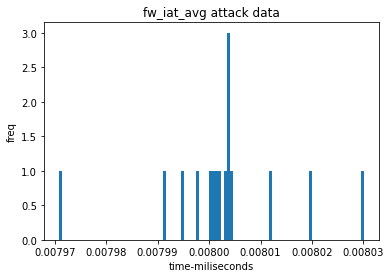

no of files in the list 20
0.0479195117950439 

0.0481045246124267 

0.0719468593597412 

0.0799950361251831 

0.0839024782180786 

0.0999994277954101 

0.1000244617462158 

0.175972580909729 

0.1879760026931762 

0.1919660568237304 

0.1959714889526367 

0.2160090208053589 

0.2281254529953003 

0.2321065664291381 

0.3079720735549927 

0.3679724931716919 

1.2720094919204712 

1.7961283922195437 

1.8143690427144368 

2.316119074821472 

benign mean -->0.4917295018831888
 benign stdev-->0.6794145426623623


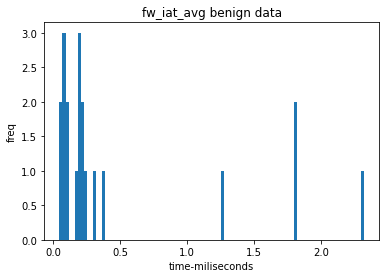

In [ ]:
df = pd.read_csv("/home/chills/Documents/Axiado-USB-Works/Reports/pl_reports.csv", usecols = ['fw_iat_avg','Label_code'])
df.to_csv("/home/chills/Documents/Axiado-USB-Works/Reports/fw_iat_reports.csv")

# plotting fw_iat_avg plots
dataframe=pd.read_csv("/home/chills/Documents/Axiado-USB-Works/Reports/fw_iat_reports.csv",usecols = ['fw_iat_avg','Label_code'])
dataframe.info()
iatdfa=dataframe.query('Label_code==1')
iatdfb=dataframe.query('Label_code==0')
print(iatdfa)
print(iatdfb)

fwiatista=iatdfa['fw_iat_avg'].values.tolist()
fwiatista_nonan=[m  for m in fwiatista if math.isnan(m)==False]
print("no of files in the list",len(fwiatista_nonan))
fwiatista_nonan.sort()
for i  in range(len(fwiatista_nonan)):
    print(fwiatista_nonan[i], "\n")
sd = np.std(fwiatista_nonan)
mean=np.mean(fwiatista_nonan)	
print("attack mean -->"+ str(mean) +"\n attack stdev-->"+str(sd))

# plot attack fw_iat_avg data  distribution graph
plt.hist(fwiatista_nonan,bins=100)
plt.xlabel('time-miliseconds')
plt.ylabel('freq')
plt.title("fw_iat_avg attack data")
plt.show()

fwiatistb=iatdfb['fw_iat_avg'].values.tolist()
fwiatistb_nonan=[m  for m in fwiatistb if math.isnan(m)==False]
print("no of files in the list",len(fwiatistb_nonan))
fwiatistb_nonan.sort()
for i  in range(len(fwiatistb_nonan)):
    print(fwiatistb_nonan[i], "\n")
sd = np.std(fwiatistb_nonan)
mean=np.mean(fwiatistb_nonan)	
print("benign mean -->"+ str(mean) +"\n benign stdev-->"+str(sd))


#plot benign fw_iat_avg data  distribution graph
plt.hist(fwiatistb_nonan,bins=100)
plt.xlabel('time-miliseconds')
plt.ylabel('freq')
plt.title("fw_iat_avg benign data")
plt.show()